In [1]:
import gfapy
import networkx as nx
import numpy as np
from itertools import product
from dimod import BQM
from dwave.system import LeapHybridSampler
from dimod.reference.samplers import SimulatedAnnealingSampler
from math import floor

In [2]:
def oriented_graph_from_file(filename):
    """Reads a .gfa file into an oriented graph.

    Args:
        filename (str): filepath to read.

    Returns:
        nx.Graph: corresponding oriented graph.
    """
    gfa = gfapy.Gfa.from_file(filename, vlevel=0)
    graph = nx.DiGraph()
    for segment_line in gfa.segments:
        graph.add_node(f'{segment_line.name}_+', sequence=segment_line.sequence, weight=segment_line.SC, start=segment_line.st)
        graph.add_node(f'{segment_line.name}_-', sequence=segment_line.sequence, weight=segment_line.SC, start=segment_line.st)
    for edge_line in gfa.edges:
        v1 = edge_line.sid1
        v2 = edge_line.sid2
        graph.add_edges_from([
            (f'{v1.name}_{v1.orient}', f'{v2.name}_{v2.orient}'),
        ])
        v1.invert()
        v2.invert()
        graph.add_edges_from([
            (f'{v2.name}_{v2.orient}', f'{v1.name}_{v1.orient}'),
        ])
    return graph

In [3]:
# g = oriented_graph_from_file('../../data/mafft+cons_clean_truncate28.gfa')
g = oriented_graph_from_file('../../data/test.gfa')

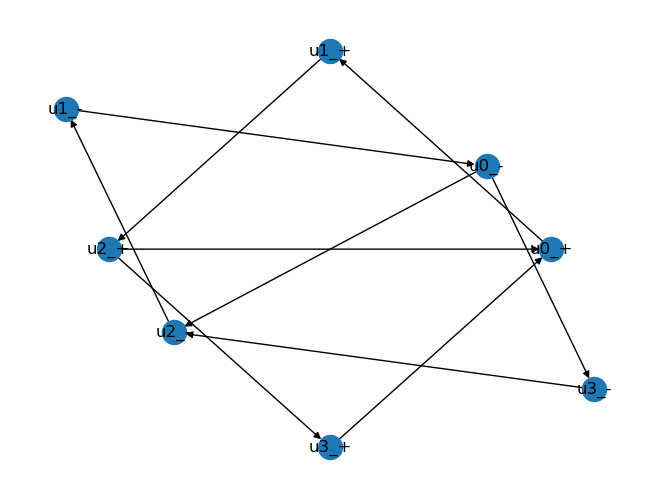

In [4]:
nx.draw_kamada_kawai(g, with_labels=True)

In [5]:
nodes = list(g.nodes)
V = int(len(nodes) / 2)
total_weight = int(sum(g.nodes[node]["weight"] for node in nodes) / 2)
alpha = 1.2
T_max = int(total_weight * alpha)
qubo_matrix = np.zeros((T_max, V + 1, 2, T_max, V + 1, 2))

lambda_t = 10 * T_max ** 2
lambda_g = T_max
lambda_end = T_max ** 2
lambda_w = T_max

# Path
for t in range(T_max):
    for i in range(V):
        for b in range(2):
            qubo_matrix[t, i, b, t, i, b] -= lambda_t
            qubo_matrix[t, V, 0, t, i, b] += 2 * lambda_t
    qubo_matrix[t, V, 0, t, V, 0] -= lambda_t
    
    for i, j in product(range(V), range(V)):
        for bi, bj in product(range(2), range(2)):
            if not (i == j and bi == bj):
                qubo_matrix[t, i, bi, t, j, bj] += lambda_t
    
# Graph
for t in range(T_max - 1):
    for i, j in product(range(V), range(V)):
        for bi, bj in product(range(2), range(2)):
            v0 = nodes[2 * i + bi]
            v1 = nodes[2 * j + bj]
            if (v0, v1) in g.edges:
                qubo_matrix[t, i, bi, t+1, j, bj] -= lambda_g

# Staying in end
for t in range(T_max - 1):
    for i in range(V):
        for b in range(2):
            qubo_matrix[t, i, b, t + 1, V, 0] -= (lambda_g - 1)
    qubo_matrix[t, V, 0, t + 1, V, 0] -= (lambda_g - 1)
    
# Leaving end
for t in range(T_max - 1):
    for i in range(V):
        for b in range(2):
            qubo_matrix[t, V, 0, t + 1, i, b] += lambda_end
            
# Weights
for i in range(V):
    for t in range(T_max):
        for b in range(2):
            qubo_matrix[t, i, b, t, i, b] -= (2 * g.nodes[nodes[2 * i]]["weight"] - 1) * lambda_w
    
    for t1, t2 in product(range(T_max), range(T_max)):
        for b1, b2 in product(range(2), range(2)):
            if not (t1 == t2 and b1 == b2):
                qubo_matrix[t1, i, b1, t2, i, b2] += lambda_w

qubo_matrix = qubo_matrix.reshape((T_max * (V+1) * 2), (T_max * (V+1) * 2))
qubo_matrix = 0.5 * (qubo_matrix + qubo_matrix.T)

# Delete excess rows and columns
qubo_matrix = np.delete(qubo_matrix, [t * (V+1) *2 + V * 2 + 1 for t in range(T_max)], 0)
qubo_matrix = np.delete(qubo_matrix, [t * (V+1) *2 + V * 2 + 1 for t in range(T_max)], 1)

In [6]:
bqm = BQM(qubo_matrix, 'BINARY')
bqm.offset = lambda_t * T_max  + lambda_w * int(sum(g.nodes[nodes[2 * i]]["weight"] ** 2 for i in range(V)))
bqm.offset

2202.0

In [7]:
bqm.num_interactions

591

In [8]:
T_max * (2 + 6 * V + 4 * V ** 2 + 4 * T_max + len(g.edges))

744

In [9]:
sim_annealer = SimulatedAnnealingSampler()

In [10]:
sampleset = sim_annealer.sample(bqm, num_reads=10)

In [11]:
sample = sampleset.first.sample
energy = sampleset.first.energy
print(energy)
sample_list = np.array(list(sample.values()))
sample_list_copy = np.copy(sample_list)
for idx in [t * (V+1) *2 + V * 2 + 1 for t in range(T_max)]:
    sample_list_copy = np.insert(sample_list_copy, idx, 0)
sample_array = sample_list_copy.reshape((T_max, V + 1, 2))

30.0


In [12]:
test_sample = np.zeros_like(sample_array)
test_sample[0, 0, 0] = 1
test_sample[1, 1, 0] = 1
test_sample[2, 2, 0] = 1
test_sample[3, 3, 0] = 1
test_sample[4, 0, 0] = 1
test_sample[5, 4, 0] = 1
test_sample_list = test_sample.reshape(T_max * (V + 1) * 2)
for idx in [t * (V+1) *2 + V * 2 + 1 for t in range(T_max -1, -1, -1)]:
    test_sample_list = np.delete(test_sample_list, idx, 0)

In [13]:
test_sample_list @ qubo_matrix @ test_sample_list + lambda_t * T_max  + lambda_w * int(sum(g.nodes[nodes[2 * i]]["weight"] ** 2 for i in range(V)))

-29.0

In [299]:
sample_list @ qubo_matrix @ sample_list + lambda_t * T_max  + lambda_w * int(sum(g.nodes[nodes[2 * i]]["weight"] ** 2 for i in range(V)))

12.0

In [300]:
t_score = 0
for t in range(T_max):
    t_score += lambda_t * (1 - sum(sample_array[t, i, b] for i in range(V) for b in range(2)) - sample_array[t, V, 0]) ** 2
print(t_score)

test_t_score = 0
for t in range(T_max):
    test_t_score += lambda_t * (1 - sum(test_sample[t, i, b] for i in range(V) for b in range(2)) - test_sample[t, V, 0]) ** 2
print(test_t_score)

0
0


In [301]:
g_score = -lambda_g * sum(
    sample_array[t, i, bi] * sample_array[t+1, j, bj] * (1 if (nodes[2 * i + bi], nodes[2 * j + bj]) in g.edges else 0)
    for t in range(T_max - 1) for i in range(V) for j in range(V) for bi in range(2) for bj in range(2))
print(g_score)

test_g_score = -lambda_g * sum(
    test_sample[t, i, bi] * test_sample[t+1, j, bj] * (1 if (nodes[2 * i + bi], nodes[2 * j + bj]) in g.edges else 0)
    for t in range(T_max - 1) for i in range(V) for j in range(V) for bi in range(2) for bj in range(2))
print(test_g_score)

-6
-24


In [302]:
g_end_score = - (lambda_g - 1) * sum(
    sum(sample_array[t, i, b] * sample_array[t+1, V, 0] for i in range(V) for b in range(2)) 
    + sample_array[t, V, 0] * sample_array[t + 1, V, 0] for t in range(T_max - 1) 
)
print(g_end_score)

test_g_end_score = - (lambda_g - 1) * sum(
    sum(test_sample[t, i, b] * test_sample[t+1, V, 0] for i in range(V) for b in range(2)) 
    + test_sample[t, V, 0] * test_sample[t + 1, V, 0] for t in range(T_max - 1) 
)
print(test_g_end_score)

0
-5


In [303]:
end_score = lambda_end * sum(sample_array[t, V, 0] * sample_array[t + 1, i, b] for t in range(T_max - 1) for i in range(V) for b in range(2))
print(end_score)

test_end_score = lambda_end * sum(test_sample[t, V, 0] * test_sample[t + 1, i, b] for t in range(T_max - 1) for i in range(V) for b in range(2))
print(test_end_score)

0
0


In [304]:
weight_score = lambda_w * sum(
    (g.nodes[nodes[2 * i]]["weight"] - sum(sample_array[t, i, b] for t in range(T_max) for b in range(2))) ** 2 for i in range(V)
)
print(weight_score)

test_weight_score = lambda_w * sum(
    (g.nodes[nodes[2 * i]]["weight"] - sum(test_sample[t, i, b] for t in range(T_max) for b in range(2))) ** 2 for i in range(V)
)
print(test_weight_score)


18.0
0.0


In [272]:
print(t_score + g_score + g_end_score + end_score + weight_score)

7.0


In [305]:
hybrid_sampler = LeapHybridSampler()
hybrid_sampleset = hybrid_sampler.sample(bqm, label="Oriented Tangle Testing")

In [313]:
hybrid_sample = hybrid_sampleset.first.sample
hybrid_energy = hybrid_sampleset.first.energy
hybrid_sample_list = np.array(list(hybrid_sample.values()))
hybrid_sample_list_copy = np.copy(hybrid_sample_list)
for idx in [t * (V+1) *2 + V * 2 + 1 for t in range(T_max)]:
    hybrid_sample_list_copy = np.insert(hybrid_sample_list_copy, idx, 0)
hybrid_sample_array = hybrid_sample_list_copy.reshape((T_max, V + 1, 2))

In [283]:
def array_to_path(arr):
    nz = np.nonzero(arr == 1)
    return [(nz[0][i], nz[1][i], nz[2][i]) for i in range(nz[0].shape[0])]
        

In [314]:
print(array_to_path(sample_array))
print(array_to_path(test_sample))
print(array_to_path(hybrid_sample_array))

[(0, 3, 1), (1, 1, 0), (2, 2, 1), (3, 2, 1), (4, 1, 1), (5, 0, 0)]
[(0, 0, 0), (1, 1, 0), (2, 2, 0), (3, 3, 0), (4, 0, 0), (5, 4, 0)]
[(0, 0, 0), (1, 1, 0), (2, 2, 0), (3, 3, 0), (4, 0, 0), (5, 4, 0)]
